In [11]:
# Install packages
import gym
import copy
import torch
from torch.autograd import Variable
import random
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
import math
import torchvision.transforms as T
import numpy as np

import time

from tqdm import tqdm
from MancalaEnv import MancalaEnv
from game import Game
from randomagent import AgentRandom
from exactagent import AgentExact
from maxagent import AgentMax

In [12]:
def plot_res(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
    # Update the window after each episode
    clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(195, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(195, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

In [13]:
def q_learning(env, model, episodes=1000, gamma=0.9, 
               epsilon=0.3, eps_decay=0.99,
               replay=False, replay_size=20, 
               title = 'DQL', double=False, 
               n_update=10, soft=False, verbose=True):
    """Deep Q Learning algorithm using the DQN. """
    final = []
    memory = []
    rewards = []
    episode_rewards = []
    episode_i=0
    sum_total_replay_time=0
    wins = []

    for episode in tqdm(range(episodes)):
        episode_i+=1
        if double and not soft:
            # Update target network every n_update steps
            if episode % n_update == 0:
                model.target_update()
        if double and soft:
            model.target_update()
        
        # Reset state
        state = env.reset()
        done = False
        total = 0
        rewards = []
        while not done:
            # Implement greedy search policy to explore the state space
            if random.random() < epsilon:
                action = env.sample(1)
            else:
                q_values = model.predict(state)
                action = torch.argmax(q_values).item()
            
            # Take action and add reward to total
            next_state, reward, done, win = env.step(action, 1)
            rewards.append(sum(rewards))
            
            # Update total and memory
            total += reward
            memory.append((state, action, next_state, reward, done))
            q_values = model.predict(state).tolist()
             
            if done:
                if not replay:
                    q_values[action] = reward
                    # Update network weights
                    model.update(state, q_values)
                episode_rewards.append(reward)
                if win:
                    wins.append(1)
                else:
                    wins.append(0)
                break

            if replay:
                t0=time.time()
                # Update network weights using replay memory
                model.replay(memory, replay_size, gamma)
                t1=time.time()
                sum_total_replay_time+=(t1-t0)
            else: 
                # Update network weights using the last step only
                q_values_next = model.predict(next_state)
                q_values[action] = reward + gamma * torch.max(q_values_next).item()
                model.update(state, q_values)

            state = next_state
        
        # Update epsilon
        epsilon = max(epsilon * eps_decay, 0.01)
        final.append(total)

        
    return final, wins

In [14]:
class DQN():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=64, lr=0.05):
            self.criterion = torch.nn.MSELoss()
            self.model = torch.nn.Sequential(
                            torch.nn.Linear(state_dim, hidden_dim),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim, hidden_dim*2),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim*2, action_dim)
                    )
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr)



    def update(self, state, y):
        """Update the weights of the network given a training sample. """
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def predict(self, state):
        """ Compute Q values for all actions using the DQL. """
        with torch.no_grad():
            return self.model(torch.Tensor(state))

In [20]:
class DQN_replay(DQN):
    #old replay function
    #def replay(self, memory, size, gamma=0.9):
        #""" Add experience replay to the DQN network class. """
        # Make sure the memory is big enough
        #if len(memory) >= size:
            #states = []
            #targets = []
            # Sample a batch of experiences from the agent's memory
            #batch = random.sample(memory, size)
            
            # Extract information from the data
            #for state, action, next_state, reward, done in batch:
                #states.append(state)
                # Predict q_values
                #q_values = self.predict(state).tolist()
                #if done:
                    #q_values[action] = reward
                #else:
                    #q_values_next = self.predict(next_state)
                    #q_values[action] = reward + gamma * torch.max(q_values_next).item()
     
                #targets.append(q_values)

            #self.update(states, targets)
    
    #new replay function
    def replay(self, memory, size, gamma=0.9):
        """New replay function"""
        #Try to improve replay speed
        if len(memory)>=size:
            batch = random.sample(memory,size)
            batch_t = list(map(list, zip(*batch))) #Transpose batch list
            states = batch_t[0]
            actions = batch_t[1]
            next_states = batch_t[2]
            rewards = batch_t[3]
            is_dones = batch_t[4]
        
            states = torch.Tensor(states)
            actions_tensor = torch.Tensor(actions)
            next_states = torch.Tensor(next_states)
            rewards = torch.Tensor(rewards)
            is_dones_tensor = torch.Tensor(is_dones)
        
            is_dones_indices = torch.where(is_dones_tensor==True)[0]
        
            all_q_values = self.model(states) # predicted q_values of all states
            all_q_values_next = self.model(next_states)
            #Update q values
            all_q_values[range(len(all_q_values)),actions]=rewards+gamma*torch.max(all_q_values_next, axis=1).values
            all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]
        
            
            self.update(states.tolist(), all_q_values.tolist())

In [21]:
print("Compiled")

Compiled


In [16]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid')/w
# Number of states
#n_state = env.observation_space.shape[0]
n_state = 14
# Number of actions
#n_action = env.action_space.n
n_action = 6
# Number of episodes
episodes = 10000
# Number of hidden nodes in the DQN
n_hidden = 50
# Learning rate
lr = 0.001






100%|██████████| 10000/10000 [06:58<00:00, 23.91it/s]


## Regular DQN Experiments

In [ ]:
# Get DQN results
env1 = MancalaEnv(reward_type = "dont_fall_behind_reward", opponent = 3)
simple_dqn = DQN(n_state, n_action, n_hidden, lr)
simple,wins = q_learning(env1, simple_dqn, episodes, gamma=.9, epsilon=0.3)

In [ ]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid')/w


simple = np.array(wins)
plt.plot(moving_average(wins,100))
plt.show

## Replay DQN Experiments

In [41]:
env1 = MancalaEnv(reward_type = "sparse_reward", opponent = 1)
env2 = MancalaEnv(reward_type = "keep_ahead_reward", opponent = 1)
env3 = MancalaEnv(reward_type = "dont_fall_behind_reward", opponent = 1)

# Get replay results
dqn_replay = DQN_replay(n_state, n_action, n_hidden, lr)
test_envs = [env1, env2, env3]
replay_results = []
for env in test_envs:
    replay_results.append(q_learning(env, dqn_replay, 
                        episodes, gamma=.9, 
                        epsilon=0.2, replay=True, 
                        title='DQL with Replay') )

  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-20-9709cbb52111>:52: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]
100%|██████████| 10000/10000 [10:35<00:00, 15.74it/s]


Text(0.5, 1.0, 'Replay_DQN vs Random Agent Rewards')

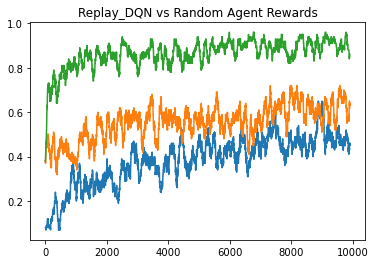

In [43]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid')/w
for replay in replay_results:
    replay = replay[1]
    replay = np.array(replay)
    plt.plot(moving_average(replay,100))
plt.title("Replay_DQN vs Random Agent Rewards")

In [33]:
len(replay_results)

3